In [1]:
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch import nn
from torch.functional import F
from copy import copy
from itertools import combinations

1. アトミックポテンシャル

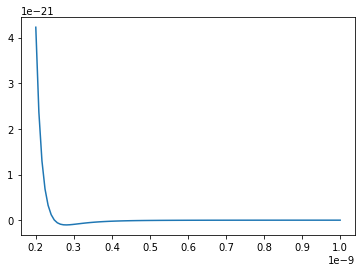

In [12]:
#*レナードジョーンズ
def e_(epsilon, sigma, r):
    return 4*epsilon*((sigma/r)**12 - (sigma/r)**6)

epsilon = 7.545*1.380649e-23
sigma = 2.49e-10 #*Angstorm -> meter
r = np.linspace(2e-10, 1e-9, 100)
energy = e_(epsilon, sigma, r)

plt.plot(r, energy)

In [13]:
2**(1/6)*sigma

2.794930500290339e-10

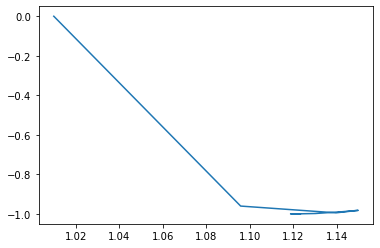

In [2]:
#*Taking gradient of distance
def e_(epsilon, sigma, r):
    return 4*epsilon*((sigma/r)**12 - (sigma/r)**6)

r = torch.ones(1, requires_grad=True)
alpha_optimizer = torch.optim.Adam([r], lr=1e-2)
phi_list, r_list = [], []

for i in range(1000):
    r_loss = e_(1, 1, r)
    alpha_optimizer.zero_grad()
    r_loss.backward()
    alpha_optimizer.step()
    if i%10==0:
        clear_output(True)
        r_list.append(r.detach().numpy()[0])
        phi_list.append(r_loss.detach().numpy())
        plt.plot(r_list, phi_list)
        plt.show()

In [37]:
atom_1, atom_2 = m.weights[0], m.weights[1]
r_inter = torch.norm(atom_1-atom_2)
def e_(r, epsilon=1, sigma=1):
    return 4*(12/sigma*((sigma/r)**13) - 6/sigma*((sigma/r)**7))
e = e_(r_inter)
e.reshape(-1,)

tensor([2999.6511], grad_fn=<ReshapeAliasBackward0>)

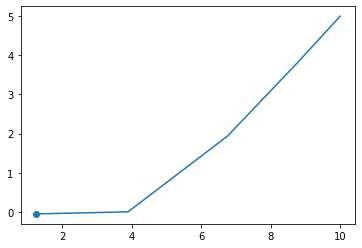

1.2444551


In [2]:
#*Taking gradient of x, y coordinates in pair cluster
def e_(epsilon, sigma, r):
    return 4*(12/sigma*((sigma/r)**13) - 6/sigma*((sigma/r)**7))

x2 = torch.tensor([10.], requires_grad=True)
y2 = torch.tensor([5.], requires_grad=True)

alpha_optimizer = torch.optim.Adam([x2, y2], lr=1e-3)
x_list, y_list = [], []

for i in range(10000):
    r = torch.sqrt(x2**2+y2**2)
    r_loss = e_(1, 1, r)
    alpha_optimizer.zero_grad()
    r_loss.backward()
    alpha_optimizer.step()
    if i%1000==0:
        x2x, x2y = x2.detach().numpy()[0], y2.detach().numpy()[0]
        x_list.append(x2x)
        y_list.append(x2y)
        clear_output(True)
        plt.plot(x_list, y_list)
        plt.scatter(x2x, x2y)
        plt.show()

print(np.linalg.norm([x2x, x2y]))

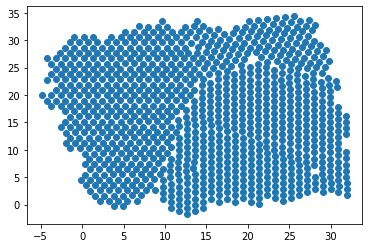

In [5]:
class Model(nn.Module):
    def __init__(self, atom_num):
        super().__init__()
        # initialize weights with random numbers
        weights = torch.rand(atom_num, 2)*torch.sqrt(torch.tensor(atom_num))
        #* row1: x-coord, row2: y-coord
        self.weights = nn.Parameter(weights)
        self.ind_inter = torch.combinations(torch.arange(self.weights.size(0)), r=2)      

    def e_(self, r, epsilon=1, sigma=1):
        return 4*epsilon*((sigma/r)**12 - (sigma/r)**6)

    def forward(self,):

        r_fromzero = torch.norm(self.weights, dim=1) #* Distance from zero point
        e_tensor = self.e_(r_fromzero)
        coord_inter = self.weights[self.ind_inter]
        r_res = torch.norm(coord_inter[:,1]-coord_inter[:,0], dim=1)
        e_res = self.e_(r_res)
        e_tensor = torch.cat((e_tensor, e_res))

        return torch.sum(e_tensor)
            
def training_loop(model, optimizer, scheduler, n=200000):

    # losses = []
    iteration = torch.arange(n).to(device)
    for i in iteration:
        loss = model.forward()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        # losses.append(loss.detach())

        # if i%1000 == 0:
        #     clear_output(True)
        #     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        #     ax1.plot(losses)
        #     coords = m.weights.clone()
        #     coords = coords.detach().numpy()
        #     ax2.scatter(coords[:,0], coords[:,1])
        #     ax2.scatter(0, 0)
        #     plt.show()
    return
# instantiate model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
m = Model(1000).to(device)
# Instantiate optimizer
opt = torch.optim.Adam(m.parameters(), lr=1e-3)
sch = torch.optim.lr_scheduler.StepLR(opt, step_size=10000, gamma = 0.98)
losses = training_loop(m, opt, sch)
weight_ = m.weights.detach().cpu().numpy()
plt.scatter(weight_[:, 0], weight_[:, 1])

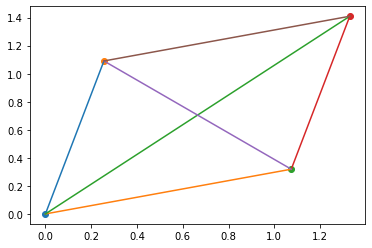

tensor([-5.0734], grad_fn=<AddBackward0>)


In [156]:
#*Taking gradient of x, y coordinates in square cluster
def e_(epsilon, sigma, r):
    return 4*epsilon*((sigma/r)**12 - (sigma/r)**6)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
#*x0, y0 = 0, 0
x1 = torch.tensor([11.]).to(device)
x1.requires_grad=True
y1 = torch.tensor([10.]).to(device)
y1.requires_grad=True
x2 = torch.tensor([6.]).to(device)
x2.requires_grad=True
y2 = torch.tensor([1.]).to(device)
y2.requires_grad=True
x3 = torch.tensor([1.]).to(device)
x3.requires_grad=True
y3 = torch.tensor([7.]).to(device)
y3.requires_grad=True

alpha_optimizer = torch.optim.Adam([x1, x2, x3, y1, y2, y3], lr=5e-2)
x_list, y_list = [], []

for i in range(20000):
    r1 = torch.sqrt(x2**2+y2**2)
    r1.retain_grad()
    r2 = torch.sqrt(x1**2+y1**2)
    r3 = torch.sqrt(x3**2+y3**2)
    r4 = torch.sqrt((x2-x1)**2+(y2-y1)**2)
    r5 = torch.sqrt((x2-x3)**2+(y2-y3)**2)
    r6 = torch.sqrt((x3-x1)**2+(y3-y1)**2)
    r_loss = (e_(1, 1, r1)+e_(1, 1, r2)+e_(1, 1, r3)+
              e_(1, 1, r4)+e_(1, 1, r5)+e_(1, 1, r6))
    alpha_optimizer.zero_grad()
    r_loss.backward(retain_graph=True)
    alpha_optimizer.step()
    if i%200==0:
        x1x, x1y = x1.cpu().detach().numpy()[0], y1.cpu().detach().numpy()[0]
        x2x, x2y = x2.cpu().detach().numpy()[0], y2.cpu().detach().numpy()[0]
        x3x, x3y = x3.cpu().detach().numpy()[0], y3.cpu().detach().numpy()[0]
        # x_list.append(x2x)
        # y_list.append(x2y)
        clear_output(True)
        # plt.plot(x_list, y_list)
        plt.scatter(0, 0)
        plt.plot([0,x3x], [0,x3y])
        plt.plot([0,x2x], [0,x2y])
        plt.plot([0,x1x], [0,x1y])
        plt.plot([x2x,x1x], [x2y,x1y])
        plt.plot([x2x,x3x], [x2y,x3y])
        plt.plot([x3x,x1x], [x3y,x1y])
        plt.scatter(x3x, x3y)
        plt.scatter(x2x, x2y)
        plt.scatter(x1x, x1y)
        plt.show()

print(r_loss)

Well, let's step into the main part

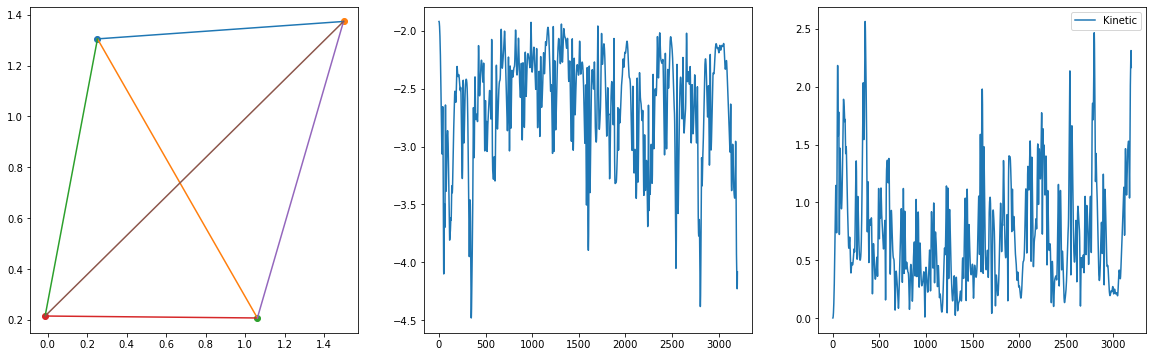

KeyboardInterrupt: 

In [2]:
#*Taking gradient of x, y coordinates in square cluster

def e_(epsilon, sigma, r):
    phi = 4*epsilon*((sigma/r)**12 - (sigma/r)**6)
    grad = 4*epsilon*(12/sigma*((sigma/r)**13) - 6/sigma*((sigma/r)**7))
    return phi, grad

def cutoff(r, r1=1.5, r2=2):
    if r <= r1:
        r_ = 1
    if r1 < r <= r2:
        r_ = 1/2*(1+math.cos(math.pi*(r-r1)/(r2-r1)))
    elif r > r2:
        r_ = 0

    return r_

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

x0 = torch.tensor([1.5]).to(device)
y0 = torch.tensor([1.4]).to(device)
x1 = torch.tensor([1.3]).to(device)
y1 = torch.tensor([0.1]).to(device)
x2 = torch.tensor([0.]).to(device)
y2 = torch.tensor([0.]).to(device)
x3 = torch.tensor([0.]).to(device)
y3 = torch.tensor([1.6]).to(device)

v0x, v0y = torch.tensor([0.]).to(device), torch.tensor([0.]).to(device)
v1x, v1y = torch.tensor([0.]).to(device), torch.tensor([0.]).to(device)
v2x, v2y = torch.tensor([0.]).to(device), torch.tensor([0.]).to(device)
v3x, v3y = torch.tensor([0.]).to(device), torch.tensor([0.]).to(device)

dt = 1e-5
m = 1
iter_time = 10000000
x_lim = 2.5
y_lim = 2.5
phi_list, kin_list = [], []

for i in range(iter_time):
    #*Total energy
    #*0 as centr atom
    r1 = torch.sqrt((x2-x0)**2+(y2-y0)**2)
    r1_phi, r1_grad = e_(1, 1, r1)
    r2 = torch.sqrt((x1-x0)**2+(y1-y0)**2)
    r2_phi, r2_grad = e_(1, 1, r2)
    r3 = torch.sqrt((x3-x0)**2+(y3-y0)**2)
    r3_phi, r3_grad = e_(1, 1, r3)
    
    #*Get the gradient
    a0x = r1_grad*(x2-x0)/r1/m + r2_grad*(x1-x0)/r2/m + r3_grad*(x3-x0)/r3/m
    a0y = r1_grad*(y2-y0)/r1/m + r2_grad*(y1-y0)/r2/m + r3_grad*(y3-y0)/r3/m
    #*Compute new coords and v0.5
    a0x = -a0x
    a0y = -a0y
    x0 += v0x*dt + 1/2*a0x*dt**2
    v0x += 1/2*a0x*dt
    y0 += v0y*dt + 1/2*a0y*dt**2
    v0y += 1/2*a0y*dt

    #*Compute new phi and v1
    r1 = torch.sqrt((x2-x0)**2+(y2-y0)**2)
    r1_phi, r1_grad = e_(1, 1, r1)
    r2 = torch.sqrt((x1-x0)**2+(y1-y0)**2)
    r2_phi, r2_grad = e_(1, 1, r2)
    r3 = torch.sqrt((x3-x0)**2+(y3-y0)**2)
    r3_phi, r3_grad = e_(1, 1, r3)
    
    a0x = r1_grad*(x2-x0)/r1/m + r2_grad*(x1-x0)/r2/m + r3_grad*(x3-x0)/r3/m
    a0y = r1_grad*(y2-y0)/r1/m + r2_grad*(y1-y0)/r2/m + r3_grad*(y3-y0)/r3/m
    a0x = -a0x
    a0y = -a0y
    v0x += 1/2*a0x*dt
    v0y += 1/2*a0y*dt

    #*1 as centr atom
    r2 = torch.sqrt((x1-x0)**2+(y1-y0)**2)
    r2_phi, r2_grad = e_(1, 1, r2)
    r4 = torch.sqrt((x2-x1)**2+(y2-y1)**2)
    r4_phi, r4_grad = e_(1, 1, r4)
    r6 = torch.sqrt((x3-x1)**2+(y3-y1)**2)
    r6_phi, r6_grad = e_(1, 1, r6)

    a1x = r2_grad*(x0-x1)/r2/m + r4_grad*(x2-x1)/r4/m + r6_grad*(x3-x1)/r6/m
    a1y = r2_grad*(y0-y1)/r2/m + r4_grad*(y2-y1)/r4/m + r6_grad*(y3-y1)/r6/m

    a1x = -a1x
    a1y = -a1y
    x1 += v1x*dt + 1/2*a1x*dt**2
    v1x += 1/2*a1x*dt 
    y1 += v1y*dt + 1/2*a1y*dt**2
    v1y += 1/2*a1y*dt

    r2 = torch.sqrt((x1-x0)**2+(y1-y0)**2)
    r2_phi, r2_grad = e_(1, 1, r2)
    r4 = torch.sqrt((x2-x1)**2+(y2-y1)**2)
    r4_phi, r4_grad = e_(1, 1, r4)
    r6 = torch.sqrt((x3-x1)**2+(y3-y1)**2)
    r6_phi, r6_grad = e_(1, 1, r6)

    a1x = r2_grad*(x0-x1)/r2/m + r4_grad*(x2-x1)/r4/m + r6_grad*(x3-x1)/r6/m
    a1y = r2_grad*(y0-y1)/r2/m + r4_grad*(y2-y1)/r4/m + r6_grad*(y3-y1)/r6/m

    a1x = -a1x
    a1y = -a1y
    v1x += 1/2*a1x*dt
    v1y += 1/2*a1y*dt

    #*2 as centr atom
    r1 = torch.sqrt((x2-x0)**2+(y2-y0)**2)
    r1_phi, r1_grad = e_(1, 1, r1)    
    r4 = torch.sqrt((x2-x1)**2+(y2-y1)**2)
    r4_phi, r4_grad = e_(1, 1, r4)
    r5 = torch.sqrt((x2-x3)**2+(y2-y3)**2)
    r5_phi, r5_grad = e_(1, 1, r5)

    a2x = r1_grad*(x0-x2)/r1/m + r4_grad*(x1-x2)/r4/m + r5_grad*(x3-x2)/r5/m
    a2y = r1_grad*(y0-y2)/r1/m + r4_grad*(y1-y2)/r4/m + r5_grad*(y3-y2)/r5/m

    a2x = -a2x
    a2y = -a2y
    x2 += v2x*dt + 1/2*a2x*dt**2
    v2x += 1/2*a2x*dt 
    y2 += v2y*dt + 1/2*a2y*dt**2
    v2y += 1/2*a2y*dt

    r1 = torch.sqrt((x2-x0)**2+(y2-y0)**2)
    r1_phi, r1_grad = e_(1, 1, r1)    
    r4 = torch.sqrt((x2-x1)**2+(y2-y1)**2)
    r4_phi, r4_grad = e_(1, 1, r4)
    r5 = torch.sqrt((x2-x3)**2+(y2-y3)**2)
    r5_phi, r5_grad = e_(1, 1, r5)

    a2x = r1_grad*(x0-x2)/r1/m + r4_grad*(x1-x2)/r4/m + r5_grad*(x3-x2)/r5/m
    a2y = r1_grad*(y0-y2)/r1/m + r4_grad*(y1-y2)/r4/m + r5_grad*(y3-y2)/r5/m

    a2x = -a2x
    a2y = -a2y
    v2x += 1/2*a2x*dt 
    v2y += 1/2*a2y*dt

    #*3 as centr atom
    r3 = torch.sqrt((x3-x0)**2+(y3-y0)**2)
    r3_phi, r3_grad = e_(1, 1, r3)
    r5 = torch.sqrt((x2-x3)**2+(y2-y3)**2)
    r5_phi, r5_grad = e_(1, 1, r5)
    r6 = torch.sqrt((x3-x1)**2+(y3-y1)**2)
    r6_phi, r6_grad = e_(1, 1, r6)

    a3x = r3_grad*(x0-x3)/r3/m + r5_grad*(x2-x3)/r5/m + r6_grad*(x1-x3)/r6/m
    a3y = r3_grad*(y0-y3)/r3/m + r5_grad*(y2-y3)/r5/m + r6_grad*(y1-y3)/r6/m

    a3x = -a3x
    a3y = -a3y
    x3 += v3x*dt + 1/2*a3x*dt**2
    v3x += 1/2*a3x*dt 
    y3 += v3y*dt + 1/2*a3y*dt**2
    v3y += 1/2*a3y*dt

    r3 = torch.sqrt((x3-x0)**2+(y3-y0)**2)
    r3_phi, r3_grad = e_(1, 1, r3)
    r5 = torch.sqrt((x2-x3)**2+(y2-y3)**2)
    r5_phi, r5_grad = e_(1, 1, r5)
    r6 = torch.sqrt((x3-x1)**2+(y3-y1)**2)
    r6_phi, r6_grad = e_(1, 1, r6)

    a3x = r3_grad*(x0-x3)/r3/m + r5_grad*(x2-x3)/r5/m + r6_grad*(x1-x3)/r6/m
    a3y = r3_grad*(y0-y3)/r3/m + r5_grad*(y2-y3)/r5/m + r6_grad*(y1-y3)/r6/m

    a3x = -a3x
    a3y = -a3y
    v3x += 1/2*a3x*dt 
    v3y += 1/2*a3y*dt

    #*Add boundary condition
    # if x0 > x_lim:
    #     x0 -= x_lim
    # elif x0 < 0:
    #     x0 += x_lim

    # if y0 > y_lim:
    #     y0 -= y_lim
    # elif y0 < 0:
    #     y0 += y_lim
        

    # if x1 > x_lim:
    #     x1 -= x_lim
    # elif x1 < 0:
    #     x1 += x_lim

    # if y1 > y_lim:
    #     y1 -= y_lim
    # elif y1 < 0:
    #     y1 += y_lim


    # if x2 > x_lim:
    #     x2 -= x_lim
    # elif x2 < 0:
    #     x2 += x_lim

    # if y2 > y_lim:
    #     y2 -= y_lim
    # elif y2 < 0:
    #     y2 += y_lim

    # if x3 > x_lim:
    #     x3 -= x_lim
    # elif x3 < 0:
    #     x3 += x_lim

    # if y3 > y_lim:
    #     y3 -= y_lim
    # elif y3 < 0:
    #     y3 += y_lim

    v_sumx = (v0x + v1x + v2x + v3x)/4
    v_sumy = (v0y + v1y + v2y + v3y)/4
    v0x -= v_sumx
    v1x -= v_sumx
    v2x -= v_sumx
    v3x -= v_sumx
    v0y -= v_sumy
    v1y -= v_sumy
    v2y -= v_sumy
    v3y -= v_sumy

    if i%(iter_time/10000)==0:
        kine_e = 1/2*m*(v0x**2+v1x**2+v2x**2+v3x**2+v0y**2+v1y**2+v2y**2+v3y**2)
        phi_sum = r1_phi + r2_phi + r3_phi + r4_phi + r5_phi + r6_phi
        phi_list.append(phi_sum[0])
        kin_list.append(kine_e[0])
        # phi_sum = r1_phi + r2_phi + r3_phi + r4_phi + r5_phi + r6_phi
        x0x, x0y = x0.cpu().detach().numpy()[0], y0.cpu().detach().numpy()[0]
        x1x, x1y = x1.cpu().detach().numpy()[0], y1.cpu().detach().numpy()[0]
        x2x, x2y = x2.cpu().detach().numpy()[0], y2.cpu().detach().numpy()[0]
        x3x, x3y = x3.cpu().detach().numpy()[0], y3.cpu().detach().numpy()[0]
        # x_list.append(x2x)
        # y_list.append(x2y)
        clear_output(True)
        # plt.plot(x_list, y_list)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

        ax1.plot([x0x,x3x], [x0y,x3y])
        ax1.plot([x0x,x2x], [x0y,x2y])
        ax1.plot([x0x,x1x], [x0y,x1y])
        ax1.plot([x2x,x1x], [x2y,x1y])
        ax1.plot([x2x,x3x], [x2y,x3y])
        ax1.plot([x3x,x1x], [x3y,x1y])
        ax1.scatter(x0x, x0y)
        ax1.scatter(x3x, x3y)
        ax1.scatter(x2x, x2y)
        ax1.scatter(x1x, x1y)

        ax2.plot(phi_list, label='Phi')
        ax3.plot(kin_list, label='Kinetic')

        plt.legend()
        plt.show()

print(e_(1,1,r1)+e_(1,1,r2)+e_(1,1,r3)+e_(1,1,r4)+e_(1,1,r5)+e_(1,1,r6))

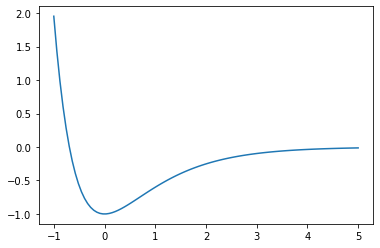

In [2]:
#*モース
def e_(d, alpha, r_r0):
    return d*(np.exp(-2*alpha*r_r0) - 2*np.exp(-alpha*r_r0))

d, alpha = 1, 1
r_r0 = np.linspace(-1, 5, 100)
energy = e_(d, alpha, r_r0)

plt.plot(alpha*r_r0, energy/d)

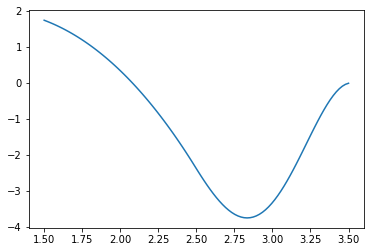

In [52]:
#*SW
#*Pair
def cutoff(r, r1=2.49, r2=3.516):
    ind_1 = np.where(r <= r1)[0]
    ind_2 = np.where(r <= r2)[0]
    ind_2 = np.where(~np.in1d(ind_2, ind_1))[0]
    r_ = np.zeros(len(r))
    for i in ind_1:
        r_[i] = 1
    for i in ind_2:
        r_[i] = 1/2*(1+np.cos(math.pi*(r[i]-r1)/(r2-r1)))

    return r_

def e_(a=1, lamda_a=1, b=1, lamda_b=1, r=1):
    return cutoff(r)*(a*r**lamda_a-b*r**lamda_b)

r = np.linspace(1.5, 3.5, 100)
energy = e_(a=3, lamda_a=1, b=1, lamda_b=2.5, r=r)

plt.plot(r, energy)

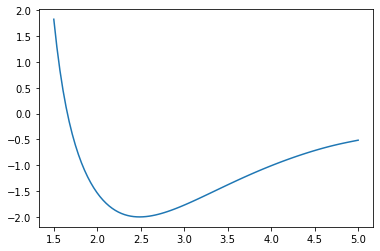

In [30]:
#*GEAM
#*Attractive force

#*Repulsive force
class v_r:
    def __init__(self, a, b, alpha, beta, k, lamda, r_, r):
        self.a = a
        self.b = b
        self.alpha = alpha
        self.beta = beta
        self.k = k
        self.lamda = lamda
        self.r_ = r_ #*安定構造の平衡長
        self.r = r

    def f_a(self):
        return 1/(1+(self.r/self.r_-self.k)**20)

    def f_b(self):
        return 1/(1+(self.r/self.r_-self.lamda)**20)

    def v_r_(self):
        left = self.f_a()*self.a*np.exp(-self.alpha*(self.r/self.r_-1))
        right = self.f_b()*self.b*np.exp(-self.beta*(self.r/self.r_-1))
        return left - right

r = np.linspace(1.5, 5, 100)
energy = v_r(a=2, b=4, alpha=4, beta=2, k=1, lamda=1.5, r_=3.516/math.sqrt(2), r=r).v_r_()

plt.plot(r, energy)

In [38]:
log_alpha = torch.zeros(1, requires_grad=True)
alpha = log_alpha.exp()
alpha_optimizer = torch.optim.Adam([log_alpha], lr=2e-3)

for i in range(3):
    alpha_loss = -log_alpha*0.1
    alpha_optimizer.zero_grad()
    alpha_loss.backward()
    alpha_optimizer.step()
    alpha = log_alpha.exp()
    print(log_alpha.grad)
    print(log_alpha)

tensor([-0.1000])
tensor([0.0020], requires_grad=True)
tensor([-0.1000])
tensor([0.0040], requires_grad=True)
tensor([-0.1000])
tensor([0.0060], requires_grad=True)
